In [1]:
# establishing environment
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from wrangle import get_aac, prep_aac, wrangle_aac

# ACQUIRE
I'll begin by acquiring the data from a local CSV file.
***

In [1]:
wrangle_aac()

NameError: name 'wrangle_aac' is not defined

In [7]:
# reading data in as DF
df = get_aac()

# previewing data
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


### Acquire Takeaways
- Acquired data from local csv file using pandas __read_csv__ function
- Data can also be acquired via the __wrangle_aac__ function in the __wrangle.py__ file
    - Note that the __wrangle_aac__ function will also prep the data for exploration

# PREPARE
I'm now going to prepare the data for exploration.
***

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [12]:
df.age_upon_outcome.value_counts().head(10)

1 year      14355
2 years     11194
2 months     9213
3 years      5157
3 months     3442
1 month      3344
4 years      2990
5 years      2691
4 months     2425
5 months     1951
Name: age_upon_outcome, dtype: int64

In [14]:
df.animal_type.value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [15]:
df.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [16]:
df.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

<a id='explain'></a>
After reviewing the data for this project, I elected to make the following changes by creating a function, __prep_aac__, located in the __wrangle.py file__. 

Alternatively, the __wrangle_aac__ function from the __wrangle.py file__ can be ran to both acquire and prep the data simultaneously.

- Drop the following columns
    - animal_id
        - Unique id's won't be useful in predicting outcomes
    - breed
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - color
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - date_of_birth
        - Since I have the age of each animal at the time of outcome, I won't need to calculate their age using this variable
    - datetime, monthyear
        - Duplicate columns that presumably reflect when a record was entered
        - Was not able to confirm what the data from this column represents so I'm dropping for now
    - outcome_subtype
        - Gives details about outcome (example: why was an animal euthanised?)
        - May prove useful but appears to only be known when the outcome is known (example: (outcome_subtype partner) (outcome_type: transfer) could only be known when an animal is set for transfer to a partner)
        - The value of this project is to create a model that will predict if an animal will be adopted, so outcome_subtype probably wouldn't be set until outcome is set, so I'm going to drop it for now
- Rename columns where appropriate to better reflect the data they represent
- Convert age_upon_outcome to value representing weeks
    - Create scaled version of this column if this becomes a model feature
- Convert animal type to categorical columns
    - is_cat
    - is_dog
    - Bird and Livestock will be converted to "is_other" since they make up a very small % of the overall amount
- Transform outcome_type to binary categorical column 'is_adopted' 
- Split sex_upon_outcome into categorical columns for neutered/spaded and sex
    - is_neutered_or_spaded
    - is_male
    - is_female
    - sex_unknown
- Drop null values
    - Very few nulls so dropping won't have a meaningful impact

### Prepping Data via prep_aac function

In [18]:
# function preps data with changes shown above
train, validate, test = prep_aac(df)

In [19]:
# previewing train df
train.head()

,animal_type,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,age_in_weeks_s,is_adopted
11259,cat,1,0,0,Male,1,0,0,1,312,0.240000,0
6981,cat,1,0,0,Male,1,0,0,0,104,0.080000,0
17670,dog,0,1,0,Male,1,0,0,1,28,0.021538,1
65805,cat,1,0,0,Male,1,0,0,1,12,0.009231,1
36724,dog,0,1,0,Male,1,0,0,1,20,0.015385,1


### Prepare Takeaways
- Prepared data with the changes outlined [here](#explain).


# Explore
I'm now going to explore the data using plots and hypothesis tests to identify drivers of adoption.
***

### age column

## Feature: animal_type

In [13]:
df.columns

Index(['age_upon_outcome', 'animal_type', 'sex_upon_outcome', 'color',
       'outcome_type', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female',
       'sex_unknown', 'sex', 'is_neutered_or_spayed', 'is_adopted',
       'age_in_weeks'],
      dtype='object')

### Crosstab

In [19]:
observed_atype = pd.crosstab(train.animal_type, train.is_adopted)

observed_atype 

is_adopted,0,1
animal_type,,
cat,9331,7114
dog,13467,11381
other,2354,165


- Crosstab reflects that the % of dog and cat adoptions is much higher than other animal types

### Visualization

In [20]:
# setting figure and text size
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

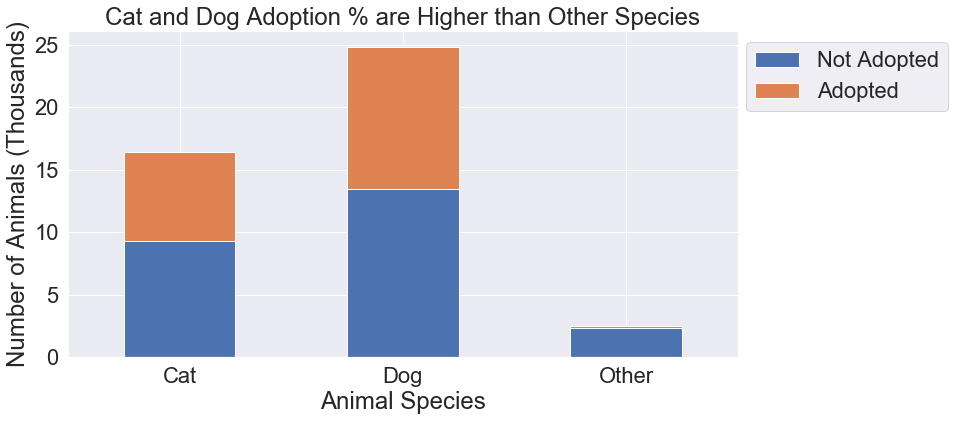

In [21]:
observed_atype.columns = ['Not Adopted', 'Adopted']
observed_atype.index = ['Cat', 'Dog', 'Other']

atype_plot = observed_atype / 1000

atype_plot.plot.bar(stacked=True, rot=0)

plt.ylabel('Number of Animals (Thousands)')
plt.xlabel('Animal Species')
plt.title('Cat and Dog Adoption % are Higher than Other Species')
plt.legend(bbox_to_anchor=(1.33,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of animal type
<br>
Ha: Adoption is not independent of animal type

In [22]:
chi2, p, degf, expected = stats.chi2_contingency(observed_atype)

print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of animal type

## Feature: sex

### Crosstab

In [23]:
observed_sex = pd.crosstab(train.sex, train.is_adopted)

observed_sex

is_adopted,0,1
sex,,
Female,9889,9329
Male,11670,9301
Unknown,3593,30


- Crosstab shows animals of an unidentified sex are rarely adopted
- Confirmed male and female animals are much more likely to be adopted
    - Males seem to have a moderage edge over females in their likelihood of being adopted

### Visualization

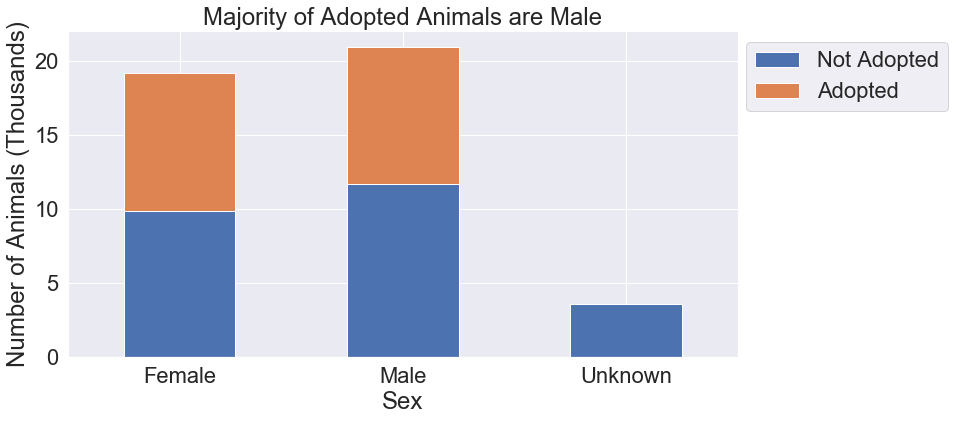

In [24]:
observed_sex.columns = ['Not Adopted', 'Adopted']

sex_plot = observed_sex / 1000

sex_plot.plot.bar(stacked=True, rot=0)

plt.ylabel('Number of Animals (Thousands)')
plt.xlabel('Sex')
plt.title('Majority of Adopted Animals are Male')
plt.legend(bbox_to_anchor=(1.33,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of sex
<br>
Ha: Adoption is not independent of sex

In [25]:
chi2, p, degf, expected = stats.chi2_contingency(observed_sex)

print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of sex

## Feature: neutered_or_spayed

### Crosstab

In [26]:
observed_nors = pd.crosstab(train.is_neutered_or_spayed, train.is_adopted)

observed_nors

is_adopted,0,1
is_neutered_or_spayed,,
0,13276,842
1,11876,17818


- Crosstab shows that neutered and spayed animals are adopted more often than their intact counterparts

### Visualization

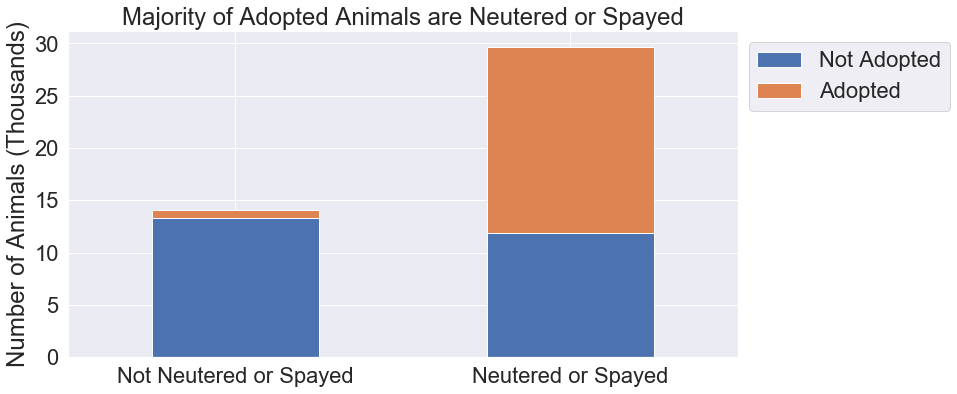

In [27]:
observed_nors.index = ['Not Neutered or Spayed', 'Neutered or Spayed']
observed_nors.columns = ['Not Adopted', 'Adopted']

nors_plot = observed_nors / 1000

nors_plot.plot.bar(stacked=True, rot=0)

plt.ylabel('Number of Animals (Thousands)')
plt.title('Majority of Adopted Animals are Neutered or Spayed')
plt.legend(bbox_to_anchor=(1,1))

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption is independent of whether an animal is neutered of spayed
<br>
Ha: Adoption is not independent of whether an animal is neutered of spayed

In [28]:
chi2, p, degf, expected = stats.chi2_contingency(observed_nors)

print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I'm rejecting the null hypothesis that adoption is independent of whether an animal is neutered or spayed

## Feature: age_in_weeks

### Visualization

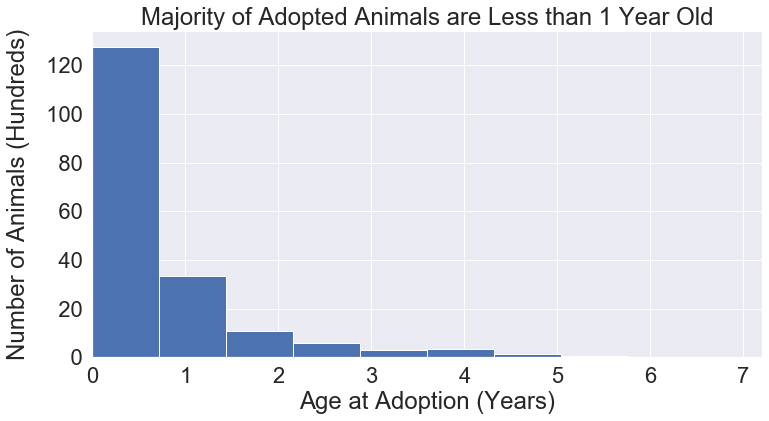

In [29]:
adopted = train[train.is_adopted == 1].age_in_weeks

fig, ax1 = plt.subplots()
ax1.hist(adopted / 52)
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:5.0f}'.format(x / 100) for x in y_vals])
ax1.set_xticklabels(np.arange(0, 18, step=1))
plt.xlabel('Age at Adoption (Years)')
plt.ylabel('Number of Animals (Hundreds)')
plt.title('Majority of Adopted Animals are Less than 1 Year Old')
ax1.margins(x=0)
plt.show()

### Two-Sample, One-Tailed T-Test

### Hypothesis
<br>
H0: The average age of animals who are adopted is equal to or greater than the average age of animals who are not adopted
<br>
Ha: The average age of animals who are adopted is less than the average age of animals who are not adopted

In [30]:
# x1 = df of animals who were adopted
# x2 = df of animals who were not adopted
x1 = train[train.is_adopted == 1].age_in_weeks
x2 = train[train.is_adopted == 0].age_in_weeks

# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p/2}')
print (f't = ',t)

alpha = .05

p = 1.7634740875777462e-182
t =  -28.919521980419926


- Since p is less than alpha and t is negative, I'm rejecting the null hypothesis that the average age of animals who are adopted is equal to or greater than the average age of animals who are not adopted

### Exploration Takeaways
- Crosstabs showed stark differences in the adoption rates of animals with animal type "unknown", unidentified sex, and those who had not been spayed or neutered from their alternate counterparts
    - These differences were also reflected in bar plots produced by their data
- Chi-squared tests showed that animal type, sex, and whether an animal is spayed or neutred are not independent of whether an animal is adopted 
- A two-sample, one-tailed t-test gave evidence that the average age of adopted animals is lower than the average age of unadopted animals

# Model
I'll now create several models that will predict whether an animal was adopted based on it's various features.
***

## Baseline

In [37]:
train.is_adopted.value_counts()

0    25152
1    18660
Name: is_adopted, dtype: int64

In [38]:
train['baseline_pred'] = 0

In [39]:
# printing performance metrics
print(classification_report(train.is_adopted, train.baseline_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     25152
           1       0.00      0.00      0.00     18660

    accuracy                           0.57     43812
   macro avg       0.29      0.50      0.36     43812
weighted avg       0.33      0.57      0.42     43812



# TRAIN

## M1

In [40]:
# setting target variable
y_train = train['is_adopted']

# setting feature for model
X_train_m1 = train[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                    'sex_unknown', 'is_neutered_or_spayed']]

# creating logistic regression object
lr_m1 = LogisticRegression(random_state=123)

# fitting model to data
lr_m1.fit(X_train_m1, y_train)

# creating column with model predictions
train['m1_prediction'] = lr_m1.predict(X_train_m1)

# printing performance metrics
print(classification_report(train.is_adopted, train.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     25152
           1       0.66      0.84      0.74     18660

    accuracy                           0.75     43812
   macro avg       0.76      0.76      0.75     43812
weighted avg       0.77      0.75      0.75     43812



# VALIDATE

In [41]:
# setting target variable
y_val = validate['is_adopted']

# setting feature for model
X_val_m1 = validate[['age_in_weeks_s','is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                     'sex_unknown','is_neutered_or_spayed']]

# creating column with model predictions
validate['m1_prediction'] = lr_m1.predict(X_val_m1)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     10815
           1       0.66      0.84      0.74      7962

    accuracy                           0.75     18777
   macro avg       0.76      0.76      0.75     18777
weighted avg       0.77      0.75      0.75     18777



# TEST

In [42]:
# setting target variable
y_test = test['is_adopted']

# setting feature for model
X_test_m1 = test[['age_in_weeks_s', 'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 
                  'sex_unknown', 'is_neutered_or_spayed']]

# creating column with model predictions
test['m1_prediction'] = lr_m1.predict(X_test_m1)

# printing performance metrics
print(classification_report(test.is_adopted, test.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76      9008
           1       0.66      0.84      0.74      6640

    accuracy                           0.75     15648
   macro avg       0.76      0.76      0.75     15648
weighted avg       0.77      0.75      0.75     15648

